In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from nb_004c import *

# Dogs and cats

## Basic data aug

In [10]:
PATH = Path('../../data/dogscats')

In [11]:
data_mean, data_std = map(tensor, ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))

In [12]:
train_tfms = [flip_lr_tfm(p=0.5),
        rotate_tfm(degrees=(-10,10.), p=0.25),
        zoom_tfm(scale=(0.8,1.2), p=0.25),
        crop_pad_tfm(row_pct=(0,1.), col_pct=(0,1.)),
        normalize_tfm(mean=data_mean,std=data_std)
]
valid_tfms = [zoom_tfm(),
              crop_pad_tfm(),
              normalize_tfm(mean=data_mean,std=data_std)
             ]

In [13]:
class TfmDataset(Dataset):
    def __init__(self, ds: Dataset, tfms: Collection[Callable] = None, **kwargs):
        self.ds,self.tfms,self.kwargs = ds,tfms,kwargs
        self.classes = self.ds.classes
        
    def __len__(self): return len(self.ds)
    def __getattr__(self, k): return getattr(self.ds, k)
#     def fns(self): return self.ds.fns
    
    def __getitem__(self,idx):
        if isinstance(idx, tuple): idx,xtra = idx
        else: xtra={}
        x,y = self.ds[idx]
        return apply_tfms(self.tfms)(x, **self.kwargs, **xtra), y

In [14]:
train_ds = FilesDataset.from_folder(PATH/'train')
valid_ds = FilesDataset.from_folder(PATH/'valid')

In [15]:
sz = 224
train_tds = TfmDataset(train_ds, train_tfms, size=sz, do_crop=True)
valid_tds = TfmDataset(valid_ds, valid_tfms, size=sz, do_crop=True)

In [48]:
data = DataBunch(train_tds, valid_tds, bs=64, num_workers=8)

In [17]:
(x,y) = next(iter(data.train_dl))

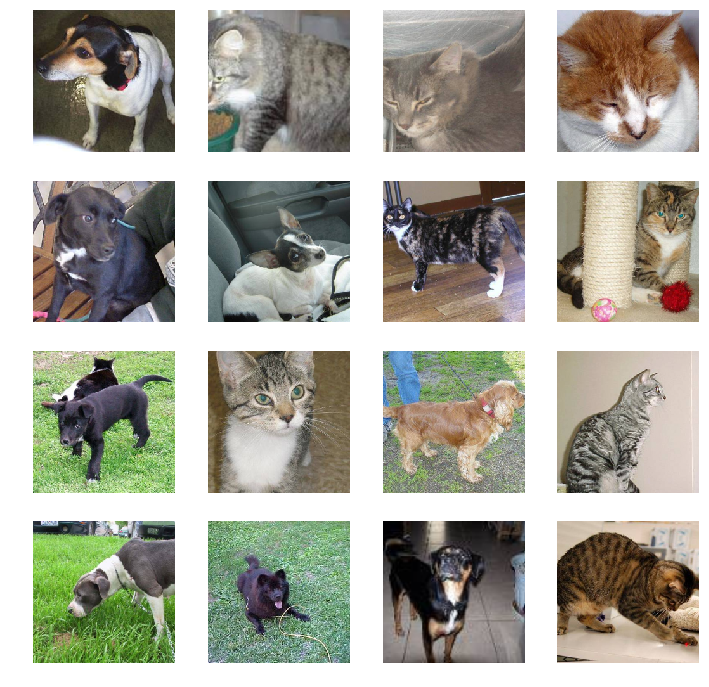

In [18]:
_,axs = plt.subplots(4,4,figsize=(12,12))
for i,ax in enumerate(axs.flatten()):
    img = x[i].cpu() * data_std[:,None,None] + data_mean[:,None,None]
    show_image(img, ax)

## Model with a new head

In [19]:
from torchvision.models import resnet34

In [20]:
arch = resnet34

In [21]:
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=None):
        super().__init__()
        sz = sz or (1,1)
        self.ap, self.mp = nn.AdaptiveAvgPool2d(sz), nn.AdaptiveMaxPool2d(sz)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

In [22]:
def create_skeleton(model, cut):
    layers = list(model.children())
    if cut != 0: layers = layers[:-cut]
    layers = layers + [AdaptiveConcatPool2d(), Flatten()]
    return nn.Sequential(*layers)

In [23]:
def num_features(m):
    c=list(m.children())
    if len(c)==0: return None
    for l in reversed(c):
        if hasattr(l, 'num_features'): return l.num_features
        res = num_features(l)
        if res is not None: return res

In [24]:
model = create_skeleton(arch(), 2)

In [25]:
num_features(model)

512

In [26]:
def bn_dp_lin(n_in, n_out, bn=True, dp=0., actn=None):
    layers = [nn.BatchNorm1d(n_in)] if bn else []
    if dp != 0: layers.append(nn.Dropout(dp))
    layers.append(nn.Linear(n_in, n_out))
    if actn is not None: layers.append(actn)
    return layers

In [27]:
def create_head(nf, nc, lin_ftrs=None, dps=None):
    lin_ftrs = [nf, 512, nc] if lin_ftrs is None else [nf] + lin_ftrs + [nc]
    if dps is None: dps = [0.25] * (len(lin_ftrs)-2) + [0.5]
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    layers = []
    for ni,no,dp,actn in zip(lin_ftrs[:-1],lin_ftrs[1:],dps,actns): 
        layers += bn_dp_lin(ni,no,True,dp,actn)
    return nn.Sequential(*layers)

In [28]:
create_head(512, 2)

Sequential(
  (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Dropout(p=0.25)
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): ReLU(inplace)
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=512, out_features=2, bias=True)
)

In [33]:
class ConvLearner(Learner):
    
    def __init__(self, data, arch, cut, pretrained=True, lin_ftrs=None, dps=None, **kwargs):
        self.skeleton = create_skeleton(arch(pretrained), cut)
        nf = num_features(self.skeleton) * 2
        self.head = create_head(nf, len(data.train_ds.classes), lin_ftrs, dps)
        model = nn.Sequential(self.skeleton, self.head)
        super().__init__(data, model, **kwargs)
    
    def freeze(self):
        for p in self.skeleton.parameters(): p.require_grad = False
    
    def unfreeze(self):
        for p in self.skeleton.parameters(): p.require_grad = True

In [34]:
learn = ConvLearner(data, arch, 2)

In [35]:
learn.freeze()

In [36]:
lr_find(learn)

0 1.6766217731468578


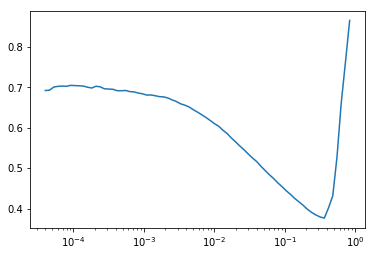

In [37]:
learn.recorder.plot()

In [49]:
learn = ConvLearner(data, arch, 2)
learn.metrics = [accuracy]
learn.freeze()

In [50]:
learn.fit(1, 4e-2)

0 0.047028493365996994 0.026280864253640176 0.991
